In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py as h5
import healpy as hp
import os

import pickle as pkl
import pandas as pd
import chime_localizations as loc

mpl.rcParams['font.size'] = 20

In [4]:
import setup

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2019_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2012_data.npy ...
Reading /

In [5]:
"""Check for overlap in maps at different time windows
use mask for CL > max_cl """

dat_loc='/data/user/jthwaites/chime_localization_data/'
dat_files=sorted(os.listdir(dat_loc))

frbs=setup.load_frbs()
sp_frbs=frbs[frbs['catalog']=='CHIME_1']

names=[d[0:12] for d in dat_files]

w=[]
for src in sp_frbs['src']:
    if src not in names:
        #if src not in ['FRB20190213A', 'FRB20181017A', 'FRB20190116B']:
        [w.append(k) for k in np.where(sp_frbs['src']==src)[0]]

w=np.unique(w)
w=sp_frbs.index[w]
print('total CHIME FRBs: ',len(sp_frbs['src']))
sp_frbs=sp_frbs.drop(w)

Loading all FRBs from catalogs
total CHIME FRBs:  534


In [6]:
print('FRBs with spatial prior: ',len(sp_frbs))
n_repbursts=sp_frbs.index[np.where(sp_frbs['repeater']==True)[0]].values

n_unique_frbs=len(np.unique(sp_frbs['src'][n_repbursts].values))
print('number of repeater bursts w spatial prior: ',len(np.where(sp_frbs['repeater']==True)[0]))
print('number of repeaters: ',n_unique_frbs)
print('individual FRBs: ',(len(sp_frbs)-(41-16)))
print('loc files: ',len(dat_files))

FRBs with spatial prior:  512
number of repeater bursts w spatial prior:  41
number of repeaters:  16
individual FRBs:  487
loc files:  487


In [7]:
def temporal_overlap(tw):
    tw=tw/86400.
    t_overlap=[]
    for i in range(len(dat_files)):
        frb_name=dat_files[i][0:12]
        f=np.where(sp_frbs['src']==frb_name)[0] 
    
        frb_time=sp_frbs['mjd'].values[f] #if this is a repeater, will have multiple times
        for m in range(len(frb_time)): 
            trange=[frb_time[m]-(tw/2.),frb_time[m]+(tw/2.)]
        
            for j in [x for x in range(len(dat_files)) if x != i]: #check all other frbs for overlap
                frb_name2= dat_files[j][0:12]
                if frb_name == frb_name2: continue
                
                f2=np.where(sp_frbs['src']==frb_name2)[0]
        
                frb_time2=sp_frbs['mjd'].values[f2] #if repeater, will have multiple values
            
                for k in range(len(frb_time2)): 
                    trange2=[frb_time2[k]-(tw/2.),frb_time2[k]+(tw/2.)]
        
                    check1= trange[0]<trange2[0] and trange[1]>trange2[0] #check for temporal overlap
                    check2= trange[0]<trange2[1] and trange[1]>trange2[1]
                    if check1 or check2: 
                        if [frb_name2,frb_name] not in t_overlap:
                            t_overlap.append([frb_name, frb_name2])
    return t_overlap
        
def spatial_overlap(names, overlap, new_nside, max_cl):
    #names= pairs of overlapping names to check
    new_localizations = pd.read_pickle(r'/home/jthwaites/FRB/sp_maps_extent.pkl')
    
    #start by checking if 90%CLs are within 1 degree from extent of CLs - 
    #faster than reading in healpix maps
    s_overlap=[]

    for i in range(len(names)):
        index1= np.where(np.asarray(new_localizations['tns_name'])==names[i][0])[0]
        index2= np.where(np.asarray(new_localizations['tns_name'])==names[i][1])[0]
        if len(index1)!=1:
            print('Error: cannot find localization for %s'%(names[i][0]))
            break
        elif len(index2)!= 1: 
            print('Error: cannot find localization for %s'%(names[i][1]))
            break
        index1 = index1[0]
        index2 = index2[0]
    
        ra_max1=new_localizations['ra'][index1]+(new_localizations['ra_unc_90'][index1]/2)+1
        ra_min1=new_localizations['ra'][index1]-(new_localizations['ra_unc_90'][index1]/2)-1
        ra_max2=new_localizations['ra'][index2]+(new_localizations['ra_unc_90'][index2]/2)+1
        ra_min2=new_localizations['ra'][index2]-(new_localizations['ra_unc_90'][index2]/2)-1
    
        if ra_min1>ra_max2 or ra_max1<ra_min2: continue
    
        dec_max1=new_localizations['dec'][index1]+(new_localizations['dec_unc_90'][index1]/2)+1
        dec_min1=new_localizations['dec'][index1]-(new_localizations['dec_unc_90'][index1]/2)-1
        dec_max2=new_localizations['dec'][index2]+(new_localizations['dec_unc_90'][index2]/2)+1
        dec_min2=new_localizations['dec'][index2]-(new_localizations['dec_unc_90'][index2]/2)-1
    
        if dec_min1>dec_max2 or dec_max1<dec_min2: continue
        #print(names[i])
        #print('ra: [%.2f, %.2f] ; [%.2f, %.2f]'%(ra_max1,ra_min1, ra_max2,ra_min2))
        #print('dec: [%.2f, %.2f] ; [%.2f, %.2f]'%(dec_max1,dec_min1, dec_max2,dec_min2))
        
        #if in previous tw overlap, don't make maps again
        if names[i] in overlap: 
            s_overlap.append(names[i])
            continue
        
        #if they have some contour overlap +/- 1 degree of contour - make healpix map
        #print('Making contour maps for %s and %s'%(names[i][0],names[i][1]))
        frb_probs, msk1=loc.make_healpix_map(names[i][0], new_nside=new_nside, max_cl=max_cl)
        frb_probs, msk2=loc.make_healpix_map(names[i][1], new_nside=new_nside, max_cl=max_cl)
        loc1=np.where(msk1)[0]
        loc2=np.where(msk2)[0]
        
        p=0
        for pixel in loc2:
            if pixel in loc1: p+=1
        
        if p==0: continue
        print('FRBs: %s and %s'%(names[i][0],names[i][1]))
        #print('Number of overlapping pixels: ',p)
        s_overlap.append(names[i])
        
    return s_overlap

In [8]:
def check_overlap(tws=np.logspace(1,6, num=16), new_nside=256, max_cl=0.9997):
    overlap_tw={}
    s_overlap_prev=[]
    for tw in tws:
        print('Time window= %i'%tw)
        if tw < 10000.: 
            print('No overlap for tw %is found'%tw)
            overlap_tw[int(tw)]=[]
            continue
            
        t_overlap=temporal_overlap(tw)
        if t_overlap==[]: return 
    
        s_overlap=spatial_overlap(t_overlap, s_overlap_prev, new_nside, max_cl)
        if s_overlap==[]: print('No overlap for tw %is found'%tw)
        overlap_tw[int(tw)]=s_overlap
        s_overlap_prev=s_overlap
    return overlap_tw

In [22]:
overlap_tw= check_overlap(tws=np.logspace(2,6, num=13),max_cl=0.9)

Time window= 100
No overlap for tw 100s found
Time window= 215
No overlap for tw 215s found
Time window= 464
No overlap for tw 464s found
Time window= 1000
No overlap for tw 1000s found
Time window= 2154
No overlap for tw 2154s found
Time window= 4641
No overlap for tw 4641s found
Time window= 10000
No overlap for tw 10000s found
Time window= 21544
No overlap for tw 21544s found
Time window= 46415
No overlap for tw 46415s found
Time window= 100000
FRBs: FRB20190408A and FRB20190409C
Time window= 215443
Time window= 464158
Time window= 1000000
FRBs: FRB20181015A and FRB20181022C
FRBs: FRB20181222E and FRB20181230E
FRBs: FRB20190128C and FRB20190206B


In [23]:
overlap_tw

{100: [],
 215: [],
 464: [],
 1000: [],
 2154: [],
 4641: [],
 10000: [],
 21544: [],
 46415: [],
 100000: [['FRB20190408A', 'FRB20190409C']],
 215443: [['FRB20190408A', 'FRB20190409C']],
 464158: [['FRB20190408A', 'FRB20190409C']],
 1000000: [['FRB20181015A', 'FRB20181022C'],
  ['FRB20181222E', 'FRB20181230E'],
  ['FRB20190128C', 'FRB20190206B'],
  ['FRB20190408A', 'FRB20190409C']]}

In [24]:
with open('overlapping_frbs_cl90.pkl', 'wb') as outfile:
    pkl.dump(overlap_tw, outfile)

In [29]:
def repeater_selfoverlap(tw=1000., document=False):
    tw=tw/86400.
    overlap=[]
    for i in range(len(dat_files)):
        frb_name=dat_files[i][0:12]
        f=np.where(sp_frbs['src']==frb_name)[0] 
    
        frb_time=sp_frbs['mjd'].values[f] #if this is a repeater, will have multiple times
        if len(frb_time)==1: continue
        
        for m in range(len(frb_time)): 
            trange=[frb_time[m]-(tw/2.),frb_time[m]+(tw/2.)]
        
            for k in [x for x in range(len(frb_time)) if x != i]:  
                trange2=[frb_time[k]-(tw/2.),frb_time[k]+(tw/2.)]
        
                check1= trange[0]<trange2[0] and trange[1]>trange2[0] #check for temporal overlap
                check2= trange[0]<trange2[1] and trange[1]>trange2[1]
                if check1 or check2: 
                    if [frb_name, frb_time[k],frb_time[m]] not in overlap:
                        overlap.append([frb_name, frb_time[m], frb_time[k]])
                        if document==True: print('    ',frb_name, frb_time[m], frb_time[k])
    return overlap

tws=np.logspace(1,6,num=16)
rep_overlap={}
for tw in tws:
    print('Time window: ',tw)
    overlap=repeater_selfoverlap(tw=tw)
    if len(overlap)!=0:
        rep_overlap[int(tw)]=overlap
    else: rep_overlap[int(tw)]=[None]

Time window:  10.0
Time window:  21.544346900318832
Time window:  46.41588833612777
Time window:  100.0
Time window:  215.44346900318823
Time window:  464.15888336127773
Time window:  1000.0
Time window:  2154.4346900318824
Time window:  4641.588833612777
Time window:  10000.0
Time window:  21544.346900318822
Time window:  46415.888336127726
Time window:  100000.0
Time window:  215443.46900318822
Time window:  464158.8833612772
Time window:  1000000.0


In [30]:
rep_overlap

{10: [None],
 21: [None],
 46: [None],
 100: [['FRB20190116B', 58499.54692066, 58499.54745883701]],
 215: [['FRB20181030A', 58421.17584521, 58421.17802826],
  ['FRB20190116B', 58499.54692066, 58499.54745883701]],
 464: [['FRB20181030A', 58421.17584521, 58421.17802826],
  ['FRB20190116B', 58499.54692066, 58499.54745883701]],
 1000: [['FRB20181030A', 58421.17584521, 58421.17802826],
  ['FRB20190116B', 58499.54692066, 58499.54745883701]],
 2154: [['FRB20181030A', 58421.17584521, 58421.17802826],
  ['FRB20190116B', 58499.54692066, 58499.54745883701]],
 4641: [['FRB20181030A', 58421.17584521, 58421.17802826],
  ['FRB20190116B', 58499.54692066, 58499.54745883701]],
 10000: [['FRB20181030A', 58421.17584521, 58421.17802826],
  ['FRB20190116B', 58499.54692066, 58499.54745883701]],
 21544: [['FRB20181030A', 58421.17584521, 58421.17802826],
  ['FRB20190116B', 58499.54692066, 58499.54745883701]],
 46415: [['FRB20181030A', 58421.17584521, 58421.17802826],
  ['FRB20190116B', 58499.54692066, 58499.54

In [31]:
with open('overlapping_repeats.pkl', 'wb') as outfile:
    pkl.dump(rep_overlap, outfile)

In [24]:
overlap_9997 = pd.read_pickle(r'/home/jthwaites/FRB/overlapping_frbs_cl9997.pkl')
overlap_99 = pd.read_pickle(r'/home/jthwaites/FRB/overlapping_frbs_cl99.pkl')
overlap_90 = pd.read_pickle(r'/home/jthwaites/FRB/overlapping_frbs_cl90.pkl')

In [32]:
selfoverlap = pd.read_pickle(r'/home/jthwaites/FRB/overlapping_repeats.pkl')

In [61]:
overlap_99

{100: [],
 215: [],
 464: [],
 1000: [],
 2154: [],
 4641: [],
 10000: [['FRB20190124B', 'FRB20190124C']],
 21544: [['FRB20190124B', 'FRB20190124C']],
 46415: [['FRB20190124B', 'FRB20190124C'], ['FRB20190519H', 'FRB20190519J']],
 100000: [['FRB20190124B', 'FRB20190124C'],
  ['FRB20190408A', 'FRB20190409C'],
  ['FRB20190519H', 'FRB20190519J'],
  ['FRB20190630C', 'FRB20190701C']],
 215443: [['FRB20190124B', 'FRB20190124C'],
  ['FRB20190408A', 'FRB20190409C'],
  ['FRB20190519H', 'FRB20190519J'],
  ['FRB20190630C', 'FRB20190701C']],
 464158: [['FRB20190124B', 'FRB20190124C'],
  ['FRB20190408A', 'FRB20190409C'],
  ['FRB20190519H', 'FRB20190519J'],
  ['FRB20190609B', 'FRB20190614A'],
  ['FRB20190630C', 'FRB20190701C']],
 1000000: [['FRB20181015A', 'FRB20181022C'],
  ['FRB20181222E', 'FRB20181230E'],
  ['FRB20190124B', 'FRB20190124C'],
  ['FRB20190128C', 'FRB20190206B'],
  ['FRB20190209A', 'FRB20190218C'],
  ['FRB20190209A', 'FRB20190218C'],
  ['FRB20190217B', 'FRB20190226C'],
  ['FRB20190328

In [64]:
tws=[int(t) for t in np.logspace(2,6, num=13)]
n_frbs={90:[],99:[],99.97:[]}
for tw in tws:
    n_99=[]
    for i in range(len(overlap_99[tw])):
        n_99.append(overlap_99[tw][i][0])
        n_99.append(overlap_99[tw][i][1])
    n_frbs[99].append(len(np.unique(n_99)))
    
    n_90=[]
    for i in range(len(overlap_90[tw])):
        n_90.append(overlap_90[tw][i][0])
        n_90.append(overlap_90[tw][i][1])
    n_frbs[90].append(len(np.unique(n_90)))
    
    n_9997=[]
    for i in range(len(overlap_9997[tw])):
        n_9997.append(overlap_9997[tw][i][0])
        n_9997.append(overlap_9997[tw][i][1])
    n_frbs[99.97].append(len(np.unique(n_9997)))
    
print(n_frbs)

{90: [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 8], 99: [0, 0, 0, 0, 0, 0, 2, 2, 4, 8, 8, 10, 22], 99.97: [0, 0, 0, 0, 0, 0, 2, 2, 4, 8, 12, 18, 38]}


In [26]:
#fig, ax = plt.subplots(figsize=(9,5))
tws=[int(t) for t in np.logspace(2,6, num=13)]

n_frbs_9997=[len(overlap_9997[k])*2 for k in tws] #no 3-way or more overlap until higher tw than 10^6
n_frbs_9997[-1]=n_frbs_9997[-1]-3 
#one repeated frb: 2 repeats of the same frb with 1 non-rep
#and one 3-way overlap

n_frbs_99=[(len(overlap_99[k]))*2 for k in tws] 
n_frbs_99[-1]=n_frbs_99[-1]-2 #same 2 rep as above

n_frbs_90=[len(overlap_90[k])*2 for k in tws] 

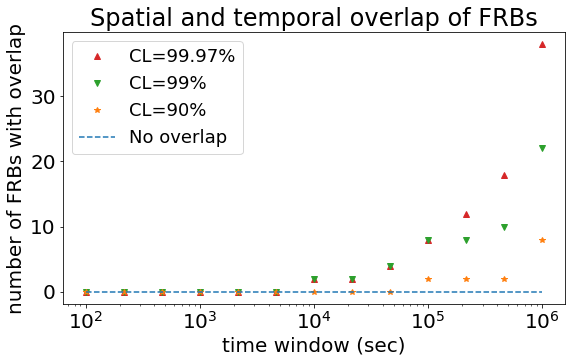

In [67]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(tws, n_frbs[99.97], '^', color='C3', label='CL=99.97%')
plt.plot(tws, n_frbs[99], 'v', color='C2', label='CL=99%')
plt.plot(tws, n_frbs[90], '*', color='C1', label='CL=90%')

plt.plot(tws, np.zeros(13),'--',color='C0', label='No overlap')

plt.ylabel(r'number of FRBs with overlap')
plt.xlabel(r'time window (sec)')
ax.set_title(r'Spatial and temporal overlap of FRBs')
plt.xscale('log')
plt.legend(fontsize=18)
plt.savefig('/home/jthwaites/FRB/plots/overlap_cls.png')